In [30]:
%matplotlib inline
import pennylane as qml
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython import display
import math

torch.manual_seed(42)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

## QCircuit parameter
n_wires = 10
n_layers = 8

## Optimizer Settings
boundary_loss_scaling = 100

# Solver settings
t_start = 0.0001
t_end   = 0.5
n_steps = 100
# Boundary values
u_0 = torch.tensor(0.75)


def derivatives_fnc(t, u):
    if isinstance(t, torch.Tensor):
        du_dt = 4*u - 6*u**2 + torch.sin(50*t) + u*torch.cos(25*t) - 0.5
    else:
        du_dt = 4*u - 6*u**2 + math.sin(50*t) + u*math.cos(25*t) - 0.5
    return du_dt


t = torch.linspace(t_start,t_end,n_steps)  
analytical_solution = torch.tensor(solve_ivp(derivatives_fnc, [t_start,t_end+0.000001], [u_0], t_eval=t).y, device=device)

In [34]:
@qml.qnode(qml.device("default.qubit.torch", wires=n_wires), interface='torch', diff_method="backprop")
def circuit(x, weights):
    # Embedding
    for i in range(n_wires):
        #qml.RY(2*i*torch.arccos((x-t_end/2)/(t_end)),wires = i)
        qml.RY(2*i*torch.arccos(x),wires = i)
    
    # Variational ansatz
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))

    # Cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(t, weights, bias, scaling):
    vcircuit = torch.vmap(circuit, in_dims=(0,None))
    return scaling[0]*vcircuit(t, weights[0]) + bias[0]

def loss_diff_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:
    u_pred = my_model(t, weights, biases, scaling) 

    grad_outputs_1 = torch.ones_like(u_pred)
    du_dt_pred = autograd.grad(u_pred, t, grad_outputs=grad_outputs_1, create_graph=True)[0]

    # ODE loss
    du_dt = derivatives_fnc(t, u_pred)
    res = du_dt_pred - du_dt
    loss_pde = torch.mean(res**2)
    return loss_pde

def loss_boundary_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:
    u_0_pred = my_model(torch.zeros_like(t), weights, biases, scaling)
    loss_boundary = torch.mean((u_0_pred - u_0)**2) 
    return boundary_loss_scaling * loss_boundary

def loss_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:

    loss_diff     = loss_diff_fnc(t, weights, biases, scaling)
    loss_boundary = loss_boundary_fnc(t, weights, biases, scaling)

    return loss_boundary + loss_diff

def loss_analytical_fnc(weights, biases, scaling):
    t = torch.linspace(t_start,t_end,n_steps, requires_grad=True)
    u_pred = my_model(t, weights, biases, scaling)
    return torch.mean((u_pred - analytical_solution)**2)

def optimize(n_iter = 100, verbose=0):
    # Solve ODE numerically
    t = torch.linspace(t_start,t_end,n_steps, requires_grad=True, device=device)

    def update(verbose):
        if verbose == 1:
            print(f"Step: {i}  Loss: {loss}")
        elif verbose == 2:
            pass
            fig = plt.figure()
            fig.set_figheight(5)
            fig.set_figwidth(20)

            # Add energy plot on column 1
            ax1 = fig.add_subplot(121)
            ax1.grid()
            ax1.plot(range(len(loss_history)), loss_history, "black", ls="solid", lw=4, alpha=0.6)
            ax1.plot(range(len(loss_diff_history)), loss_diff_history, "g", ls="dotted",lw=2)
            ax1.plot(range(len(loss_boundary_history)), loss_boundary_history, "r", ls="dashed",lw=2)
            ax1.plot(range(len(loss_analytical_history)), loss_analytical_history, "b", ls="dashdot",lw=2)
            ax1.legend(["total loss", "diff loss", "boundary loss", "analytical loss"], fontsize=9, loc=1)
            ax1.set_yscale('log')
            ax1.set_xlabel("Optimization step", fontsize=13)
            ax1.set_ylabel("Loss", fontsize=13)
            ax1.set_title("Loss",fontsize=16)

            ax2 = fig.add_subplot(122)
            ax2.grid()
            u = my_model(t, weights, biases, scaling)
            ax2.plot(t.cpu().detach(), analytical_solution.cpu().T, "g",linewidth=5, alpha=0.3)
            ax2.plot(t.cpu().detach(), u.cpu().detach(), "r", ls="dashed", lw=2)
            ax2.legend(["analytical", "quantum"], fontsize=13)
            ax2.set_xlabel("t", fontsize=13)
            ax2.set_ylabel("u", fontsize=13)
            ax2.set_title("Function Values",fontsize=16)
            
            display.clear_output(wait=True)
            plt.show()
            print(f"Step: {i}  Loss: {loss}")
    
    for i in range(1,n_iter+1):
        opt.zero_grad()
        loss = loss_fnc(t,weights, biases, scaling)
        # loss = loss_analytical_fnc(weights, biases, scaling)
        loss.backward()
        opt.step()

        loss_history.append(loss.cpu().detach())
        loss_diff_history.append(loss_diff_fnc(t, weights, biases, scaling).cpu().detach())
        loss_boundary_history.append(loss_boundary_fnc(t, weights, biases, scaling).cpu().detach())
        loss_analytical_history.append(loss_analytical_fnc(weights, biases, scaling).cpu().detach())

        if i%10 == 0 : update(verbose)
        
weights = [torch.rand((n_layers, n_wires), requires_grad=True, device=device)]        
biases = [torch.rand(1, requires_grad=True, device=device)]
scaling = [torch.rand(1, requires_grad=True, device=device)]

parameters = weights + biases + scaling

# Create optimizer
opt = torch.optim.Adam(parameters, lr=0.01)
loss_history = []
loss_diff_history = []
loss_boundary_history = []
loss_analytical_history = []

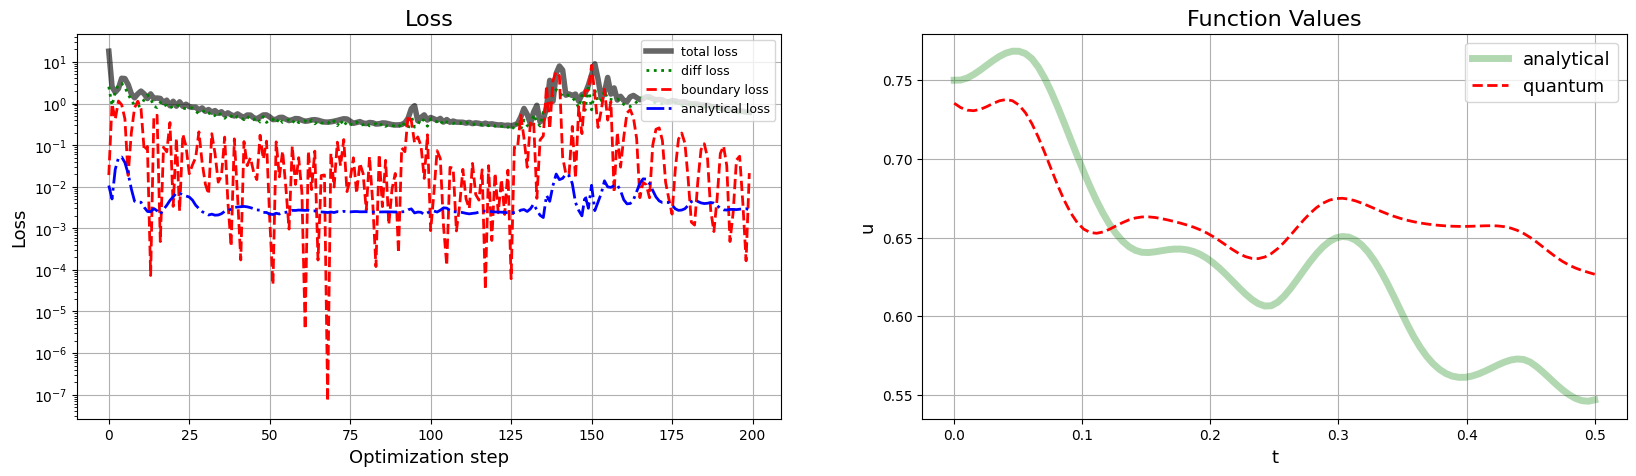

Step: 100  Loss: 0.6164951130652796
2min 7s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [36]:
opt.param_groups[0]["lr"] = 0.2
%timeit -r1 -n1 optimize(n_iter=100, verbose=2)

---
# Parameter Study

In [2]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import BayesSearchCV, gp_minimize

search_space = []
search_space.append(Integer(2,8,name="n_qubits"))
search_space.append(Integer(1,8,name="n_entanglement_layers"))
search_space.append(Real(1e-4,1, name="learning_rate", prior='log-uniform'))
search_space.append(Integer(1,1e6, name="boundary_scaling", prior='log-uniform'))
search_space.append(Integer(10,1e5, name="collocation_points", prior='log-uniform'))


@use_named_args(search_space)
def config_and_training_wrapper(n_qubits, n_entanglement_layers, learning_rate, boundary_scaling, collocation_points):
    
    n_wires = n_qubits
    n_layers= n_entanglement_layers
    
    # Solver settings
    t_start = 0.0001
    t_end   = 0.9
    n_steps = collocation_points
    
    t = torch.linspace(t_start,t_end,n_steps,requires_grad=True)  

    weights = [torch.rand((n_layers, n_wires), requires_grad=True)]        
    biases = [torch.rand(1, requires_grad=True)]
    scaling = [torch.rand(1, requires_grad=True)]

    parameters = weights + biases + scaling

    # Create optimizer
    opt = torch.optim.Adam(parameters, lr=learning_rate)
    loss_history = []
    loss_diff_history = []
    loss_boundary_history = []
    loss_analytical_history = []


    @qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
    def circuit(x, weights):
        # Embedding
        for i in range(n_wires):
            #qml.RY(2*i*torch.arccos((x-t_end/2)/(t_end)),wires = i)
            qml.RY(2*i*torch.arccos(x),wires = i)
        
        # Variational ansatz
        qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))

        # Cost function
        return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

    def my_model(t, weights, bias, scaling):
        vcircuit = torch.vmap(circuit, in_dims=(0,None))
        return scaling[0]*vcircuit(t, weights[0]) + bias[0]

    def loss_diff_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:
        u_pred = my_model(t, weights, biases, scaling) 

        grad_outputs_1 = torch.ones_like(u_pred)
        du_dt_pred = autograd.grad(u_pred, t, grad_outputs=grad_outputs_1, create_graph=True)[0]

        # ODE loss
        du_dt = derivatives_fnc(t, u_pred)
        res = du_dt_pred - du_dt
        loss_pde = torch.mean(res**2)
        return loss_pde

    def loss_boundary_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:
        u_0_pred = my_model(torch.zeros_like(t), weights, biases, scaling)
        loss_boundary = torch.mean((u_0_pred - u_0)**2) 
        return boundary_scaling * loss_boundary

    def loss_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:

        loss_diff     = loss_diff_fnc(t, weights, biases, scaling)
        loss_boundary = loss_boundary_fnc(t, weights, biases, scaling)

        return loss_boundary + loss_diff

    def loss_analytical_fnc(weights, biases, scaling):
        t = torch.linspace(t_start,t_end,n_steps, requires_grad=True)
        u_pred = my_model(t, weights, biases, scaling)

        return torch.mean((u_pred - analytical_solution)**2)

    for i in range(1,201):
        opt.zero_grad()
        loss = loss_fnc(t,weights, biases, scaling)
        loss.backward()
        opt.step()
        loss_history.append(loss.detach())



    return min([float(tensor) for tensor in loss_history])

res = gp_minimize(config_and_training_wrapper, search_space, n_calls=50, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 36.0194
Function value obtained: 1.2081
Current minimum: 1.2081
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 506.8084
Function value obtained: 12.3351
Current minimum: 1.2081
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1202.0522
Function value obtained: 0.4505
Current minimum: 0.4505
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.1775
Function value obtained: 1.5049
Current minimum: 0.4505
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 20.2205
Function value obtained: 1.9932
Current minimum: 0.4505
Iteration No: 6 started. Ev

In [1]:
from skopt.plots import plot_convergence, plot_objective

plot_objective(res, size=5, levels=50)

NameError: name 'res' is not defined

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

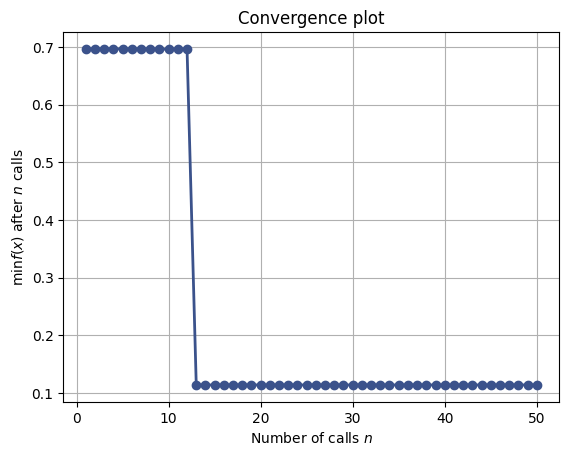

In [24]:
plot_convergence(res)

In [23]:
res.x

[4, 4, 1.0, 1, 10]